In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [3]:
df = pd.read_csv("GOOG.csv")  # Google stock price dataset
df.head()

Date       High        Low       Open      Close      Volume  \
0  2004-08-23  56.528118  54.321388  55.168217  54.495735  18342897.0   
1  2004-08-24  55.591629  51.591621  55.412300  52.239197  15319808.0   
2  2004-08-25  53.798351  51.746044  52.284027  52.802086   9232276.0   
3  2004-08-26  53.773445  52.134586  52.279045  53.753517   7128620.0   
4  2004-08-27  54.107193  52.647663  53.848164  52.876804   6241307.0   

   Adj Close  
0  54.495735  
1  52.239197  
2  52.802086  
3  53.753517  
4  52.876804

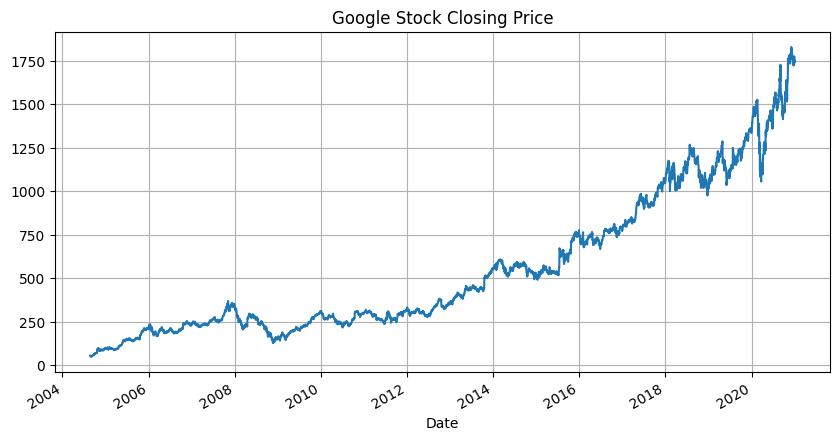

In [4]:
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['Close'].plot(title="Google Stock Closing Price", figsize=(10, 5))
plt.grid(True)
plt.show()

In [5]:
data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length=60):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

sequence_length = 60
x, y = create_sequences(data_scaled, sequence_length)

split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

print("Training shape:", x_train.shape, y_train.shape)
print("Testing shape:", x_test.shape, y_test.shape)

Training shape: (3248, 60, 1) (3248, 1)
Testing shape: (812, 60, 1) (812, 1)


In [6]:
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(x_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3952e-05 - val_loss: 4.3354e-05
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.4962e-05 - val_loss: 5.0964e-05
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.9905e-05 - val_loss: 1.1338e-04
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6150e-05 - val_loss: 3.7718e-05
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.0301e-05 - val_loss: 1.1262e-04


In [8]:
loss = model.evaluate(x_test, y_test)
print(f"\nTest Loss (MSE): {loss:.6f}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6888e-04

Test Loss (MSE): 0.001858


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


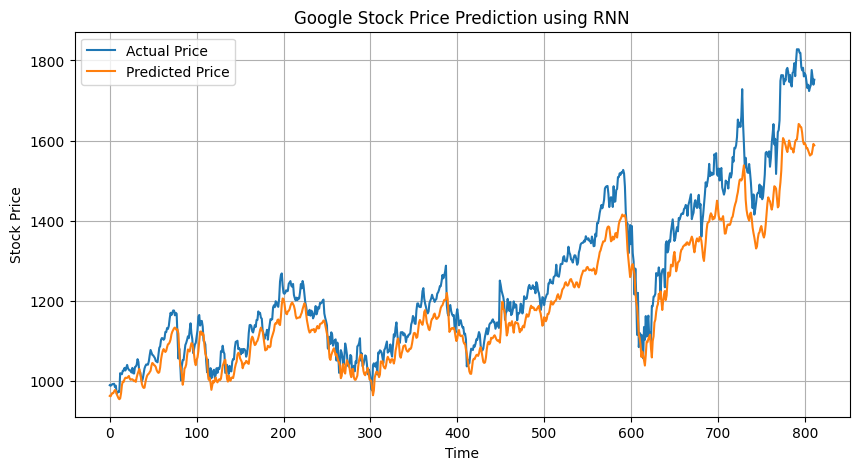

In [9]:
predicted = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Google Stock Price Prediction using RNN")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
last_sequence = data_scaled[-sequence_length:]
next_input = last_sequence.reshape((1, sequence_length, 1))
next_pred = model.predict(next_input)
next_price = scaler.inverse_transform(next_pred)
print(f"Predicted next day's stock price: ${next_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted next day's stock price: $1578.59


In [11]:
future_predictions = []
input_seq = data_scaled[-sequence_length:]  # last 60 days

for _ in range(7):  # next 7 days
    pred = model.predict(input_seq.reshape(1, sequence_length, 1))
    future_predictions.append(pred[0][0])
    input_seq = np.append(input_seq, pred)[1:]  # slide window forward

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Day 1: $1578.59
Day 2: $1542.65
Day 3: $1469.88
Day 4: $1395.40
Day 5: $1344.09
Day 6: $1287.97
Day 7: $1239.77


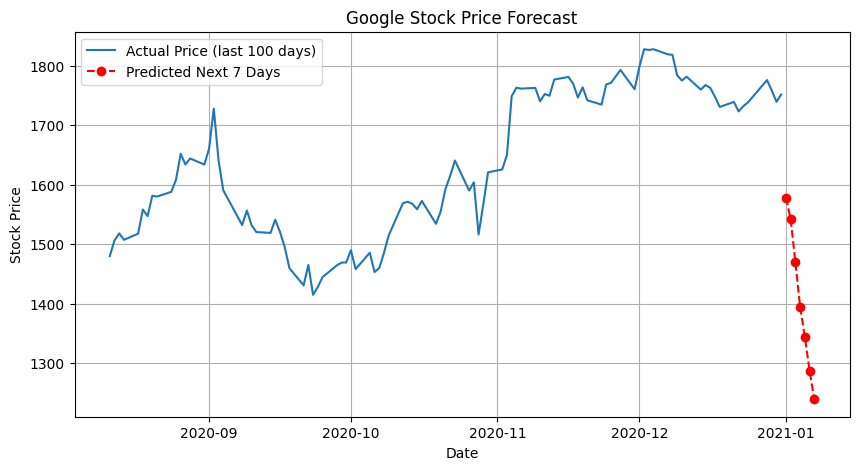

In [12]:
last_actual_day = df.index[-1]
future_dates = pd.date_range(last_actual_day + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(10, 5))
plt.plot(df.index[-100:], df['Close'].values[-100:], label="Actual Price (last 100 days)")
plt.plot(future_dates, future_predictions, 'r--o', label="Predicted Next 7 Days")
plt.title("Google Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()